In [40]:
import h5py
from collections import defaultdict
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import librosa
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [8]:
file_path = 'bird_spectrograms.hdf5'  
f = h5py.File(file_path, 'r')

print("Available keys (species):")
print(list(f.keys()))

Available keys (species):
['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']


In [9]:
with h5py.File(file_path, 'r') as f:
    keys = list(f.keys())
    X_list, y_list = [], []
    for idx, species in enumerate(keys):
        data = np.transpose(f[species][:], (2, 0, 1))  # (samples, 128, 517)
        labels = np.full(len(data), idx)
        X_list.append(data)
        y_list.append(labels)

X = np.concatenate(X_list)
y = np.concatenate(y_list)

In [10]:
perm = np.random.permutation(len(X))
X = X[perm]
y = y[perm]
X_tensor = torch.tensor(X[:, np.newaxis, :, :], dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [20]:
def downsample_classes(X, y):
    class_indices = defaultdict(list)
    for i, label in enumerate(y):
        class_indices[label].append(i)

    min_class_count = min(len(indices) for indices in class_indices.values())
    balanced_indices = []
    for label, indices in class_indices.items():
        balanced_indices.extend(np.random.choice(indices, min_class_count, replace=False))

    np.random.shuffle(balanced_indices)
    return X[balanced_indices], y[balanced_indices]

In [21]:
class SpectrogramDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        x = (x - x.mean()) / (x.std() + 1e-6)
        x = x.unsqueeze(0)
        y = self.y[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

In [22]:
class AdvancedBirdCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv_block3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.global_pool = torch.nn.AdaptiveAvgPool2d((4, 4))
        self.dropout = torch.nn.Dropout(0.4)
        self.fc1 = torch.nn.Linear(128 * 4 * 4, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

X_bal, y_bal = downsample_classes(X, y)
X_test_bal, y_test_bal = downsample_classes(X_test, y_test)

augment = torch.nn.Sequential(
    T.FrequencyMasking(freq_mask_param=15),
    T.TimeMasking(time_mask_param=25)
)

In [24]:
train_dataset = SpectrogramDataset(X_bal, y_bal, transform=augment)
test_dataset = SpectrogramDataset(X_test_bal, y_test_bal)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(y_bal))
model = AdvancedBirdCNN(num_classes=num_classes).to(device)
criterion = FocalLoss(alpha=None, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [25]:
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []
best_val_loss = float('inf')
patience = 5
trigger_times = 0
best_model_state = None

for epoch in range(50):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).long()
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (outputs.argmax(dim=1) == yb).sum().item()
        total += yb.size(0)

    train_loss_hist.append(running_loss / len(train_loader))
    train_acc_hist.append(correct / total)

    
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device).long()
            outputs = model(xb)
            val_loss += criterion(outputs, yb).item()
            val_correct += (outputs.argmax(dim=1) == yb).sum().item()
            val_total += yb.size(0)

    val_loss_epoch = val_loss / len(test_loader)
    val_acc_epoch = val_correct / val_total
    val_loss_hist.append(val_loss_epoch)
    val_acc_hist.append(val_acc_epoch)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss_hist[-1]:.4f} | "
          f"Val Loss: {val_loss_epoch:.4f} | Train Acc: {train_acc_hist[-1]:.4f} | "
          f"Val Acc: {val_acc_epoch:.4f}")

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_model_state = model.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"→ No improvement. Early stopping trigger {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("→ Early stopping!")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

Epoch 01 | Train Loss: 2.2879 | Val Loss: 2.0552 | Train Acc: 0.0878 | Val Acc: 0.1019
Epoch 02 | Train Loss: 2.0871 | Val Loss: 2.0326 | Train Acc: 0.1014 | Val Acc: 0.1296
Epoch 03 | Train Loss: 2.0193 | Val Loss: 1.9933 | Train Acc: 0.1374 | Val Acc: 0.1574
Epoch 04 | Train Loss: 2.0104 | Val Loss: 1.9700 | Train Acc: 0.1171 | Val Acc: 0.1667
Epoch 05 | Train Loss: 1.9400 | Val Loss: 1.9184 | Train Acc: 0.1689 | Val Acc: 0.1481
Epoch 06 | Train Loss: 1.9212 | Val Loss: 1.9044 | Train Acc: 0.1847 | Val Acc: 0.1852
Epoch 07 | Train Loss: 1.8467 | Val Loss: 1.8643 | Train Acc: 0.2117 | Val Acc: 0.2037
Epoch 08 | Train Loss: 1.7759 | Val Loss: 1.8008 | Train Acc: 0.2477 | Val Acc: 0.2222
Epoch 09 | Train Loss: 1.7973 | Val Loss: 1.7806 | Train Acc: 0.1914 | Val Acc: 0.2870
Epoch 10 | Train Loss: 1.7042 | Val Loss: 1.7462 | Train Acc: 0.2320 | Val Acc: 0.2685
Epoch 11 | Train Loss: 1.7233 | Val Loss: 1.7087 | Train Acc: 0.2387 | Val Acc: 0.2963
Epoch 12 | Train Loss: 1.6666 | Val Loss: 1

<Figure size 720x576 with 0 Axes>

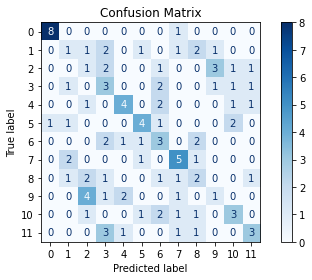

In [27]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

class_names = [str(i) for i in range(12)]  
plot_confusion_matrix(conf_matrix, class_names)

In [33]:
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
classification_rep = classification_report(all_labels, all_preds, digits=2, zero_division=0)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"\n Final Test Accuracy: {test_accuracy:.2%}\n")
print("Classification Report:\n")
print(classification_rep)


 Final Test Accuracy: 35.19%

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.17      0.11      0.13         9
           2       0.10      0.11      0.11         9
           3       0.21      0.33      0.26         9
           4       0.50      0.44      0.47         9
           5       0.50      0.44      0.47         9
           6       0.25      0.33      0.29         9
           7       0.45      0.56      0.50         9
           8       0.22      0.22      0.22         9
           9       0.17      0.11      0.13         9
          10       0.38      0.33      0.35         9
          11       0.43      0.33      0.38         9

    accuracy                           0.35       108
   macro avg       0.36      0.35      0.35       108
weighted avg       0.36      0.35      0.35       108



In [35]:
top3_correct = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        top3 = model(xb).topk(3, dim=1).indices.cpu()
        top3_correct += (top3 == yb.unsqueeze(1)).any(dim=1).sum().item()

top3_acc = top3_correct / len(test_loader.dataset)
print(f"Top-3 Accuracy: {top3_acc:.2%}")


Top-3 Accuracy: 62.04%


The top-3 accuracy shows that the model understands certain class boundaries to a good extent(0,4,5).
It tells us that 2/3 chances it willl predict the right class

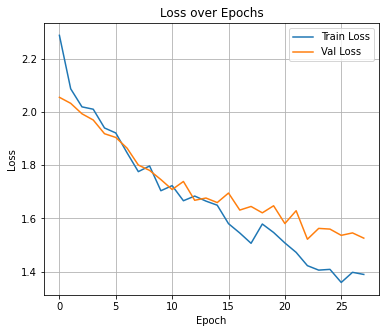

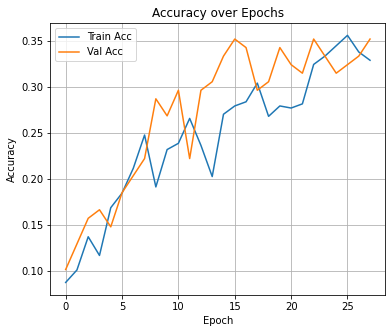

In [36]:
plt.figure(figsize=(6, 5))
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend(); plt.grid(True)
plt.show()

Testing (with 3 given .mp3 files)

In [37]:
def preprocess_audio_librosa(file_path, target_sr=22050, target_shape=(128, 517)):
    y, sr = librosa.load(file_path, sr=target_sr)
    num_samples = target_sr * 3
    if len(y) > num_samples:
        y = y[:num_samples]
    else:
        y = np.pad(y, (0, num_samples - len(y)))

    mel_spec = librosa.feature.melspectrogram(y=y, sr=target_sr, n_mels=128)
    spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    spec_db = (spec_db - np.mean(spec_db)) / (np.std(spec_db) + 1e-6)

    if spec_db.shape[1] > target_shape[1]:
        spec_db = spec_db[:, :target_shape[1]]
    elif spec_db.shape[1] < target_shape[1]:
        pad_width = target_shape[1] - spec_db.shape[1]
        spec_db = np.pad(spec_db, ((0, 0), (0, pad_width)))

    tensor = torch.tensor(spec_db, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return tensor

In [41]:
def predict_from_mp3(model, file_path, class_labels):
    model.eval()
    x = preprocess_audio_librosa(file_path).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
        top3_idx = probs.argsort()[-3:][::-1]
        return [(class_labels[i], probs[i]) for i in top3_idx]

In [43]:
test_files = [
    "test1.mp3",
    "test2.mp3",
    "test3.mp3"
]

class_labels = ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin',
                'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']

results = []
for file_path in test_files:
    top_preds = predict_from_mp3(model, file_path, class_labels)
    row = {
        "file": os.path.basename(file_path),
        "Top-1": f"{top_preds[0][0]} ({top_preds[0][1]:.2%})",
        "Top-2": f"{top_preds[1][0]} ({top_preds[1][1]:.2%})",
        "Top-3": f"{top_preds[2][0]} ({top_preds[2][1]:.2%})"
    }
    results.append(row)

df = pd.DataFrame(results)
print(df.to_string(index=False))


     file           Top-1           Top-2           Top-3
test1.mp3 amecro (21.66%) whcspa (14.08%) norfli (12.16%)
test2.mp3 amecro (17.91%) whcspa (14.32%) norfli (12.55%)
test3.mp3 amecro (21.73%) whcspa (14.48%) norfli (12.78%)
